In [ ]:
library("dplyr")
library("Seurat")
library("patchwork")
library("Matrix")
library("biomaRt")  
library("ggplot2")
library("celda")  
library("DoubletFinder") 
library("harmony")  
library("presto")  
library("biomaRt")
library("glmGamPoi")
library("RColorBrewer")
set.seed(1234)

## Import data

In [ ]:
adult_Turin <- readRDS('/Adult_Brain_Neurons_29yo_SCT.rds')

In [ ]:
grafts <- readRDS('/ENSEMBL_markers_annotation.rds')

In [ ]:
grafts_noAstro <- subset(grafts, subset = annotation_unified != 'Astrocytes')

In [ ]:
colnames(grafts_noAstro@meta.data)[colnames(grafts_noAstro@meta.data) == "annotation_unified"] = "Cell_population"
colnames(adult_Turin@meta.data)[colnames(adult_Turin@meta.data) == "supercluster_term"] = "Cell_population"

In [ ]:
conf_adult_Turin <- merge(grafts_noAstro, y = adult_Turin, project = 'Single-cell-Analysis')
conf_adult_Turin <- JoinLayers(conf_adult_Turin, assay = 'RNA')
rownames(conf_adult_Turin@assays$RNA@layers$counts) <- rownames(conf_adult_Turin)

## SCT

In [ ]:
conf_adult_Turin <- SCTransform(conf_adult_Turin, vst.flavor = "v2", variable.features.n = 3000,  ncells = 5000)

## PCA

In [ ]:
human_sub_genes <- readRDS('/GTF_HumanGenes_IDandName.rds')

human_s.genes <- subset(human_sub_genes, subset = name %in% cc.genes$s.genes)
s.genes <- human_s.genes$gene_id
human_g2m.genes <- subset(human_sub_genes, subset = name %in% cc.genes$g2m.genes)
g2m.genes <- human_g2m.genes$gene_id

## Clustering and UMAP

In [ ]:
#Cell cycle scoring
s.genes <- human_s.genes$gene_id
g2m.genes <- human_g2m.genes$gene_id
conf_adult_Turin <- CellCycleScoring(conf_adult_Turin, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)
conf_adult_Turin$CC.Difference <- conf_adult_Turin$S.Score - conf_adult_Turin$G2M.Score
#Run PCA on variable genes
conf_adult_Turin <- RunPCA(conf_adult_Turin, features = VariableFeatures(object = conf_adult_Turin), npcs = 50, reduction.name = "pca")
ElbowPlot(conf_adult_Turin, reduction = "pca", ndims = 50)
conf_adult_Turin$samples <- ifelse(conf_adult_Turin$dataset == 'Conforti', conf_adult_Turin$orig.ident, 'Adult_public')
conf_adult_Turin <- RunUMAP(conf_adult_Turin, dims = 1:num_dims, reduction = "pca", reduction.name = "umap", reduction.key = "umap")

## Batch correction

In [ ]:
conf_adult_Turin <- RunHarmony(conf_adult_Turin, 'samples', orig.reduction = "pca", new.reduction = "harmonyPca")

In [ ]:
options(repr.plot.width=15, repr.plot.height=10)   
num_dims <- 50

#Clustering loop
conf_adult_Turin <- FindNeighbors(conf_adult_Turin, reduction = "harmony", dims = 1:num_dims)
for (res_val in seq(0.05, 0.65, 0.2)) {
  conf_adult_Turin <- FindClusters(conf_adult_Turin, resolution = res_val, method = 4)
  #Plot clusters
conf_adult_Turin = RunUMAP(conf_adult_Turin, dims = 1:num_dims, reduction = "harmony", reduction.name = "harmony_umap")
  p <- DimPlot(conf_adult_Turin, reduction = "harmony_umap", group.by = "seurat_clusters", pt.size = 1, label = TRUE, label.size = 8, raster = FALSE) + 
        ggtitle(paste0("Seurat clusters - resolution = ", res_val)) + xlab("UMAP_1") + ylab("UMAP_2")
  plot(p)
}

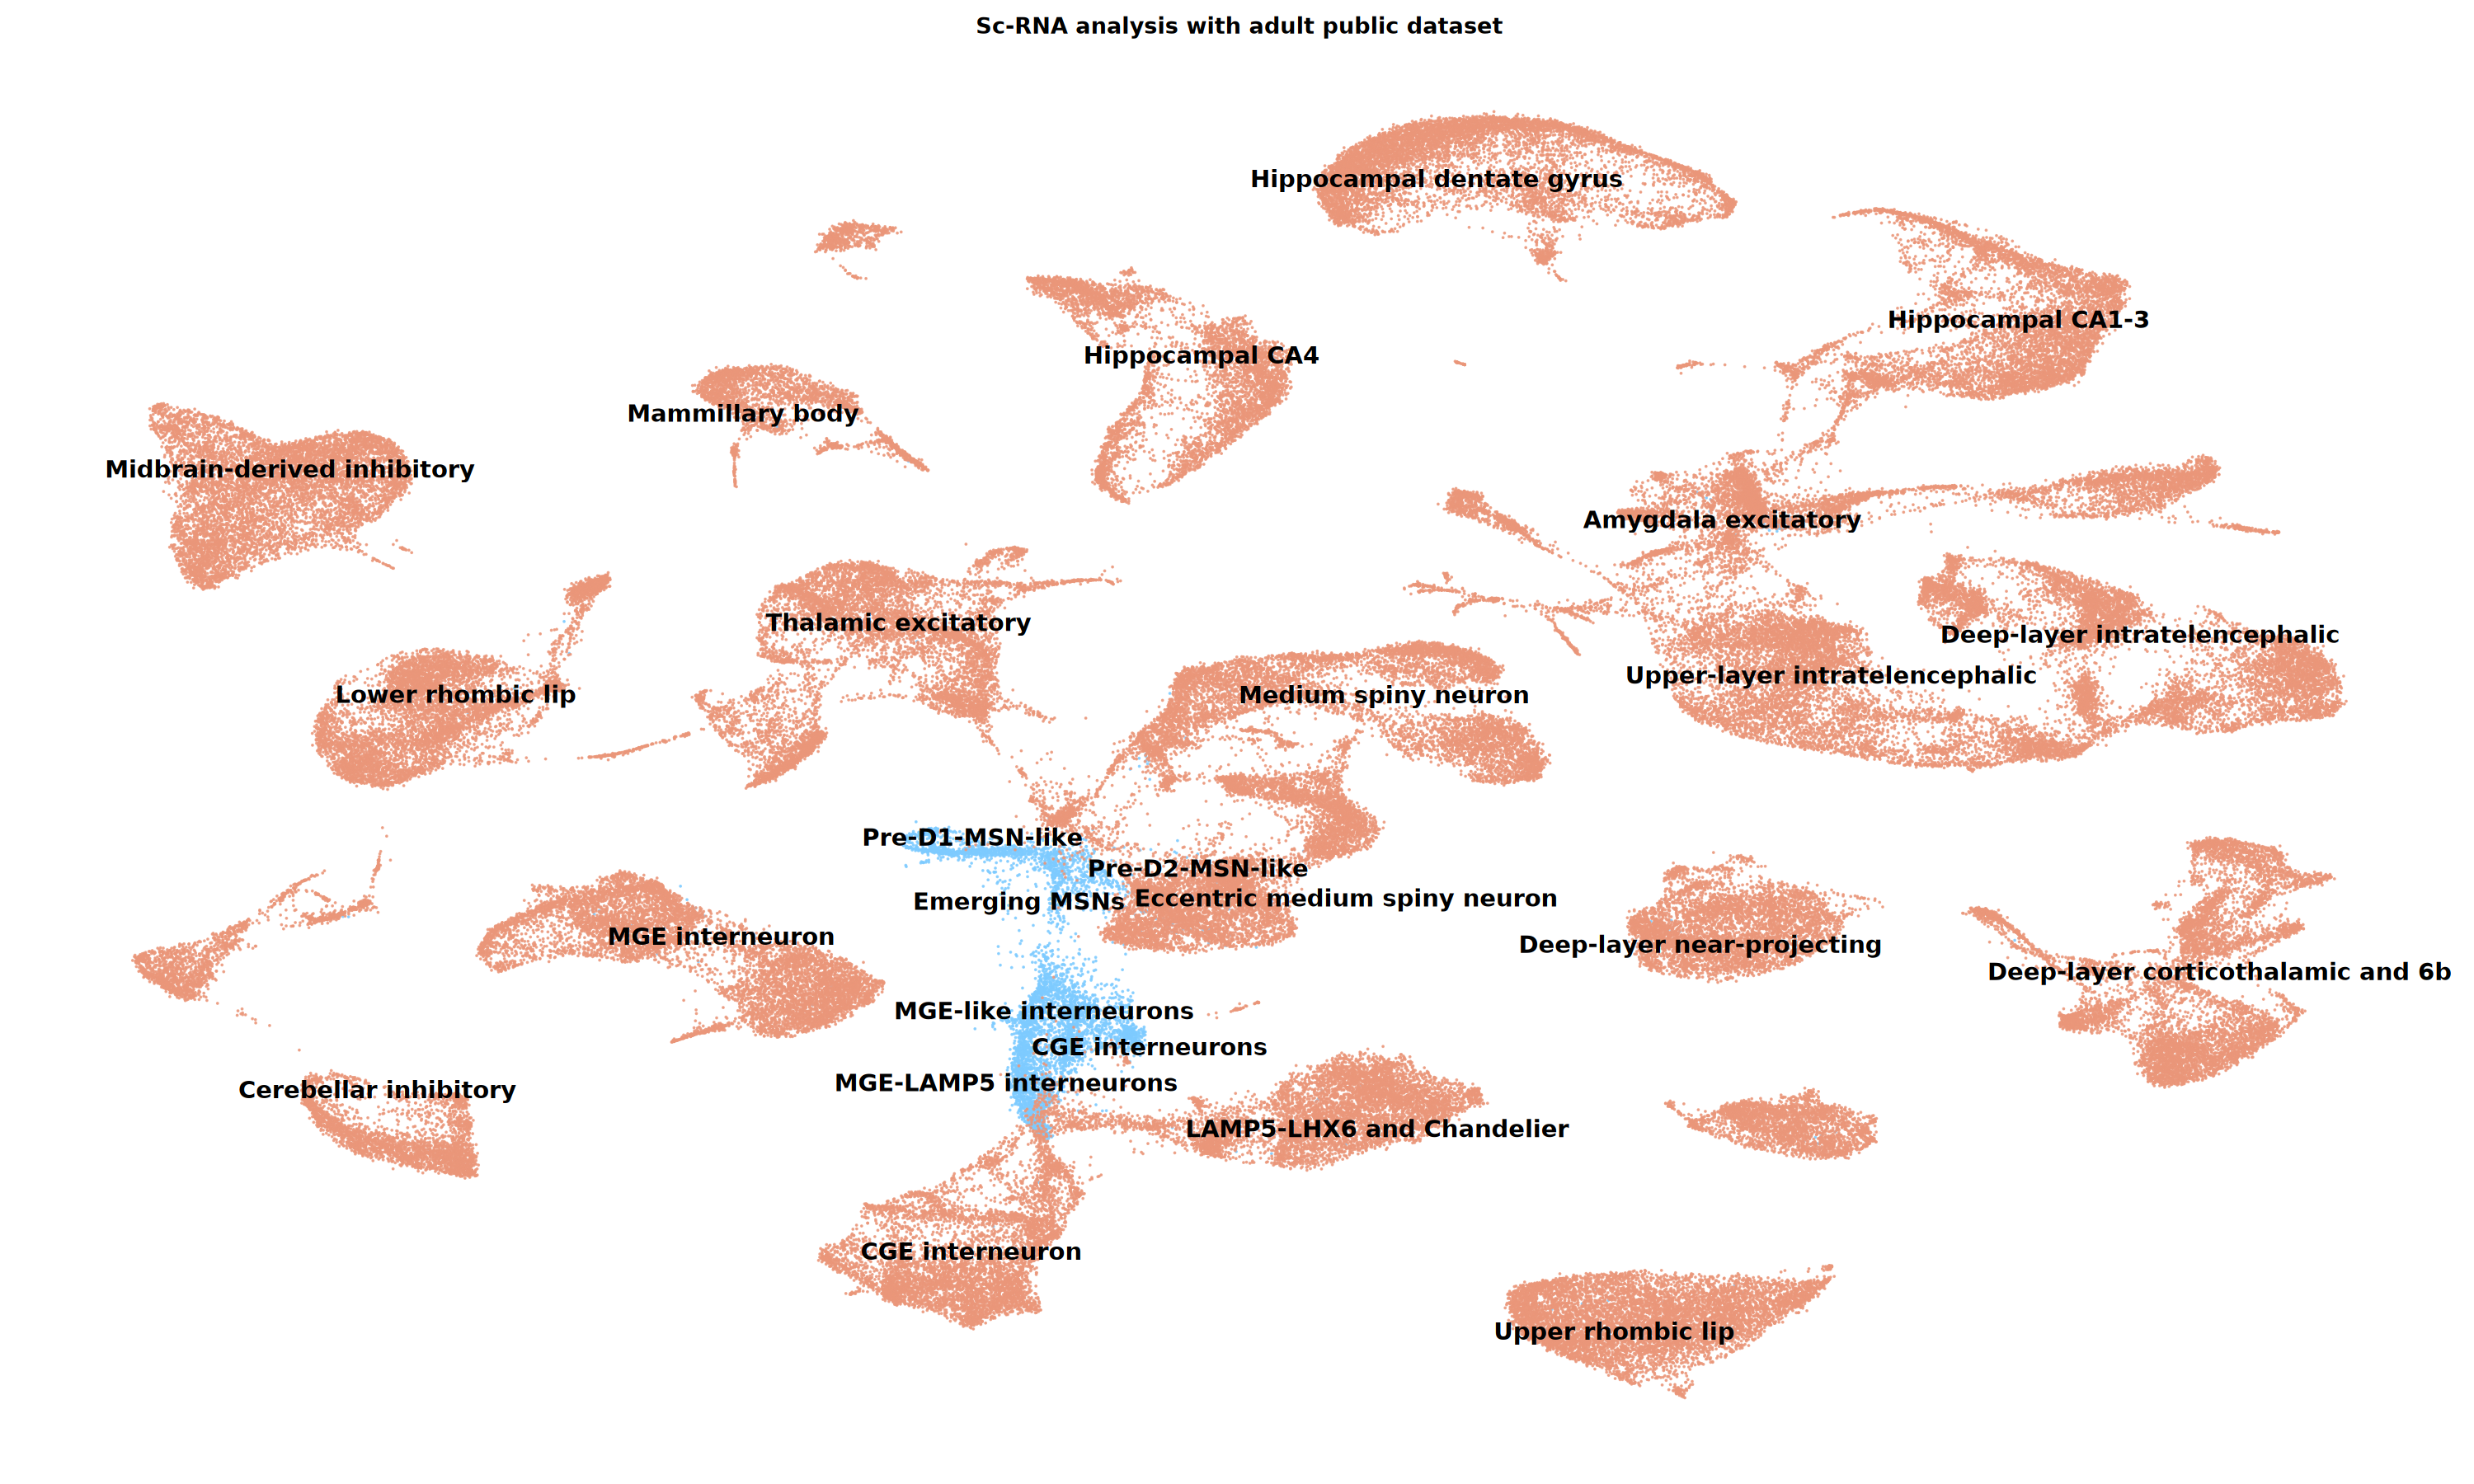

In [26]:
options(repr.plot.width=25, repr.plot.height=15)   

colors = c(rep('darksalmon', 3), '#7DCAFF', rep('darksalmon', 4), '#7DCAFF', rep('darksalmon', 8), rep('#7DCAFF', 2), 'darksalmon', rep('#7DCAFF', 2),rep('darksalmon', 3))

p <- DimPlot(conf_adult_Turin, reduction = "harmony_umap", group.by = "annotation_markers2", pt.size = 0.01, alpha = 0.8, raster = F,
             cols = colors) + NoLegend() + ggtitle('Sc-RNA analysis with adult public dataset') +
    NoAxes()
    LabelClusters(p, id = "annotation_markers2",  fontface = "bold", size = 6)